# Steps Performed:
   - Segregated dataset into 3 groups
   - Converted temp columns into seasons
   - Imputed the missing values
   - Handled the 0s in year_build feature
   - Label encoded the 3 categorical features
   - Feature Scaling
   - Feature Selection
   - Modeling
   - Tuning and remodelling
   - Conclusions

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

%matplotlib inline

In [17]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [18]:
train.head(3)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2


In [19]:
target = train['site_eui']                 # capturing target variable
row_id = test.iloc[:,62:]                  # capturing the ids for submission file

In [20]:
# drop features from dataframe
def drop(df, *features):
    for i in features:
        df.drop(i, axis=1, inplace=True)

In [21]:
test.head(3)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75759


In [22]:
drop(train, 'id')
drop(test, 'id')

In [23]:
# Segreggating the features into 3 sectors for better analysis
train_temp = train.iloc[:, 8:44]
train_fog = train.iloc[:, 44:62]
train_imp = train.iloc[:,:8]

test_temp = test.iloc[:, 8:44]
test_fog = test.iloc[:, 44:62]
test_imp = test.iloc[:,:8]

### 1. Temp columns 

From the EDA done earlier it was clear that the temperature columns are highly correlated. We can remove the min and max columns for each month and proceed with just the avg temp of each month. Below, we have dropped the min max columns and grouped the remaining temp features into different season which brought down the temp features count from 36 to just 4.

In [24]:
def temp_to_seasons(df):
    '''
    This function takes a dataframe and performs 3 tasks:
        1. Drop the min and max columns
        2. Converts the remaining into 4 seasons
        3. Drops the avg columns
    '''
    to_drop = []   
    
    # drop all the min and max columns
    for i in df.columns:
        if 'avg' not in i:
            to_drop.append(i)
    drop(df, to_drop)                        
    
    # grouping in seasons
    df['spring'] = (df['march_avg_temp'] + df['april_avg_temp'] + df['may_avg_temp'])/3
    df['summer'] = (df['june_avg_temp'] + df['july_avg_temp'] + df['august_avg_temp'])/3
    df['fall'] = (df['september_avg_temp'] + df['october_avg_temp'] + df['november_avg_temp'])/3
    df['winter'] = (df['december_avg_temp'] + df['january_avg_temp'] + df['february_avg_temp'])/3
    
    #dropping the avg columns
    to_drop = []
    for i in df.columns:
        if 'avg' in i:
            to_drop.append(i)
    drop(df, to_drop)

In [25]:
temp_to_seasons(train_temp)
temp_to_seasons(test_temp)

### 2. Fog Columns 

In [26]:
train_fog.head(2)

,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN
1,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0


In [27]:
missing = [i for i in train_fog.columns if train_fog[i].isnull().sum() != 0]    # capturing the cols with missing values

In [28]:
# As we have a couple of outliers we will impute using the median
train_fog.fillna(train_fog.median(), inplace=True)
test_fog.fillna(test_fog.median(), inplace=True)

### 3. Other Features

In [29]:
train_imp[train_imp['year_built'] == 0]                # year_built 0 doesn't make any sense

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION
353,1,State_1,Commercial,Lodging_Hotel,204392.0,0.0,61.0,59.1
955,2,State_1,Commercial,Lodging_Hotel,204392.0,0.0,63.0,2.4
2159,3,State_1,Commercial,Lodging_Hotel,204392.0,0.0,63.0,9.1
3415,4,State_1,Commercial,Lodging_Hotel,204392.0,0.0,68.0,9.1
4535,5,State_1,Commercial,Lodging_Hotel,204392.0,0.0,76.0,9.1
5571,6,State_1,Commercial,Lodging_Hotel,204392.0,0.0,78.0,45.7


We see a couple of 0's in year_built. Replacing that with median

In [30]:
train_imp.replace(to_replace=0, value=train_imp['year_built'].median(), inplace=True)
test_imp.replace(to_replace=0, value=test_imp['year_built'].median(), inplace=True)

In [31]:
# Imputing missing values with median

train_imp.fillna(train_imp.median(), inplace=True)
test_imp.fillna(test_imp.median(), inplace=True)

In [32]:
train_imp.head(3)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8


In [33]:
# Label Encoding
columns = [i for i in train_imp.columns if train_imp[i].dtypes == 'object']

def LE(train, test):
    le = LabelEncoder()
    for col in train.columns:
        if train[col].dtypes == 'object':
            train[col] = le.fit_transform(train[col])
            le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
            test[col] = test[col].apply(lambda x: le_dict.get(x, -1))
    return train, test

train_df, test_df = LE(train_imp, test_imp)

In [34]:
train_imp.head(3)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION
0,1,0,0,13,61242.0,1942.0,11.0,2.4
1,1,0,0,55,274000.0,1955.0,45.0,1.8
2,1,0,0,48,280025.0,1951.0,97.0,1.8


### Joining the 3 datasets

In [35]:
train_clean = pd.concat([train_temp, train_fog, train_imp], axis=1)
test_clean = pd.concat([test_temp, test_fog, test_imp], axis=1)

In [36]:
# adding the target variable in train df
train_clean['site_eui'] = target

In [37]:
# Saving the clean data
# train_clean.to_csv('clean_train.csv', index=False)
# test_clean.to_csv('clean_test.csv', index=False)

### Feature Scaling 

In [38]:
# Before Scaling
train_clean.head(3)

,spring,summer,fall,winter,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,...,days_with_fog,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,site_eui
0,55.349462,61.795699,60.48871,50.12116,115,2960,16.59,0.0,0,56.972603,...,104.0,1,0,0,13,61242.0,1942.0,11.0,2.4,248.682615
1,55.349462,61.795699,60.48871,50.12116,115,2960,16.59,0.0,0,56.972603,...,12.0,1,0,0,55,274000.0,1955.0,45.0,1.8,26.500150
2,55.349462,61.795699,60.48871,50.12116,115,2960,16.59,0.0,0,56.972603,...,12.0,1,0,0,48,280025.0,1951.0,97.0,1.8,24.693619


In [39]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

num_features = [i for i in train_clean.columns]
num_features.remove('site_eui')
num_features

train_clean[num_features] = scaler.fit_transform(train_clean[num_features])
test_clean[num_features] = scaler.transform(test_clean[num_features])

In [40]:
# After Scaling
train_clean.head(3)

,spring,summer,fall,winter,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,...,days_with_fog,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,site_eui
0,0.492197,-3.711943,0.655635,2.242963,-2.776721,-1.655776,-2.439607,-1.635885,-0.940595,0.355007,...,-0.063586,-2.28876,-2.735028,-1.163089,-1.110481,-0.424272,-0.323749,-2.153383,-0.611748,248.682615
1,0.492197,-3.711943,0.655635,2.242963,-2.776721,-1.655776,-2.439607,-1.635885,-0.940595,0.355007,...,-2.940165,-2.28876,-2.735028,-1.163089,2.496116,0.437535,0.079789,-0.750060,-0.621640,26.500150
2,0.492197,-3.711943,0.655635,2.242963,-2.776721,-1.655776,-2.439607,-1.635885,-0.940595,0.355007,...,-2.940165,-2.28876,-2.735028,-1.163089,1.895016,0.461940,-0.044377,1.396200,-0.621640,24.693619


The target variable normalization didn't help in improving model performance!

<AxesSubplot:>

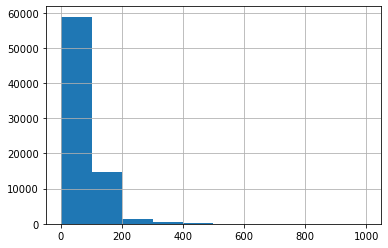

In [41]:
# Check target column
train_clean['site_eui'].hist()

<AxesSubplot:>

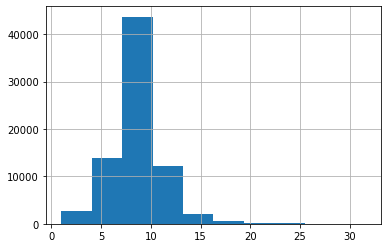

In [42]:
np.sqrt(train_clean['site_eui']).hist()

In [43]:
# train_clean['site_eui'] = np.sqrt(train_clean['site_eui'])

### Feature Selection 

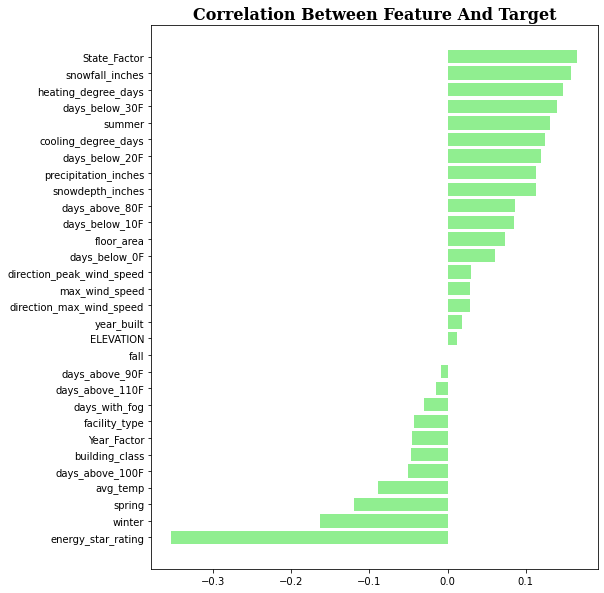

str

In [44]:
# creating a correlation dataframe with the corr values
corr_df = train_clean.select_dtypes('number').drop('site_eui', axis=1).corrwith(train_clean['site_eui']).sort_values().reset_index().rename(columns = {'index':'feature' ,0:'correlation'})

#Plotting
fig , ax = plt.subplots(figsize  = (8,10))
ax.barh(y =corr_df.feature , width = corr_df.correlation, color='lightgreen' )
ax.set_title('correlation between feature and target'.title() ,
            fontsize = 16 , fontfamily = 'serif' , fontweight = 'bold')
plt.show()
type(corr_df.feature[0])

In [45]:
# List of features having minimal correlation
columns_with_low_correlation = corr_df[(corr_df.correlation >-0.03) & (corr_df.correlation<0.03)].feature.tolist()
columns_with_low_correlation

['days_above_110F',
 'days_above_90F',
 'fall',
 'ELEVATION',
 'year_built',
 'direction_max_wind_speed',
 'max_wind_speed']

In [46]:
# Dropping the irrelevant columns
drop(train_clean, columns_with_low_correlation)
drop(test_clean, columns_with_low_correlation)

### Modeling

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [48]:
def model_score(model, txt):
    '''
    Printing the performance metrics:
    R2 Square, Mean Absolute, Mean Squared Error, Root Mean Squared Error
    
    Parameters:
    model: Trained Model
    txt: To print the results for each model
    '''
    #Predicting the SalePrices using test set 
    y_pred = model.predict(x_test)            
    x_pred = model.predict(x_train)

    # Printing the metrics, comparing model's performance on seen and unseen data
    print('MSE on train:',metrics.mean_squared_error(y_train, x_pred))
    print('MSE on test:',metrics.mean_squared_error(y_test, y_pred))
    return x_pred, y_pred

In [49]:
# train test split
X= train_clean.drop('site_eui',axis=1)
y= train_clean['site_eui']
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

### Light GBM

In [50]:
lgb= lgb.LGBMRegressor(n_estimators = 900 , max_depth=10, learning_rate=0.01, importance_type='gain', colsample_bytree = 0.4)
lgb.fit(x_train,y_train)

lgbm_x_pred, lgbm_y_pred = model_score(lgb, 'LGBM Regression Scores: ')

MSE on train: 1836.6792427270896
MSE on test: 1820.8521727431712


### CatBoost

In [51]:
# Tuning

# params = { 'max_depth': range(3,11,1),
#            'learning_rate': np.arange(0.01,0.1,0.1),
#            'n_estimators': np.arange(100,1000,100),
#            'colsample_bytree': np.arange(0.3, 0.7,0.1)}

# xgbr = XGBRegressor(seed = 20)
# clf = RandomizedSearchCV(estimator=xgbr,
#                    cv=3,
#                    param_distributions=params,
#                    scoring='neg_root_mean_squared_error', 
#                    verbose=1,n_jobs=-1)
# clf.fit(x_train,y_train)
# print("Best parameters:", clf.best_params_)
# print("Lowest mean squared wrr: ", (clf.best_score_))

In [52]:
cbr = CatBoostRegressor(learning_rate=0.01, max_depth=10, n_estimators=900, subsample=0.5)
cbr.fit(x_train, y_train)

0:	learn: 58.7681775	total: 222ms	remaining: 3m 19s
1:	learn: 58.6136496	total: 265ms	remaining: 1m 58s
2:	learn: 58.4290799	total: 309ms	remaining: 1m 32s
3:	learn: 58.2592996	total: 353ms	remaining: 1m 19s
4:	learn: 58.0807183	total: 400ms	remaining: 1m 11s
5:	learn: 57.8980295	total: 445ms	remaining: 1m 6s
6:	learn: 57.7235268	total: 492ms	remaining: 1m 2s
7:	learn: 57.5967266	total: 521ms	remaining: 58.1s
8:	learn: 57.4248110	total: 567ms	remaining: 56.1s
9:	learn: 57.2590081	total: 611ms	remaining: 54.4s
10:	learn: 57.1385579	total: 630ms	remaining: 50.9s
11:	learn: 57.0191658	total: 656ms	remaining: 48.6s
12:	learn: 56.8618167	total: 701ms	remaining: 47.8s
13:	learn: 56.7108677	total: 745ms	remaining: 47.1s
14:	learn: 56.5571718	total: 788ms	remaining: 46.5s
15:	learn: 56.3941237	total: 831ms	remaining: 45.9s
16:	learn: 56.2416197	total: 875ms	remaining: 45.5s
17:	learn: 56.0906713	total: 924ms	remaining: 45.3s
18:	learn: 55.9467625	total: 967ms	remaining: 44.8s
19:	learn: 55.815

161:	learn: 47.1183207	total: 7.77s	remaining: 35.4s
162:	learn: 47.0913237	total: 7.81s	remaining: 35.3s
163:	learn: 47.0696477	total: 7.86s	remaining: 35.3s
164:	learn: 47.0514563	total: 7.9s	remaining: 35.2s
165:	learn: 47.0293856	total: 7.95s	remaining: 35.2s
166:	learn: 47.0063533	total: 8s	remaining: 35.1s
167:	learn: 46.9876079	total: 8.05s	remaining: 35.1s
168:	learn: 46.9677097	total: 8.1s	remaining: 35s
169:	learn: 46.9471760	total: 8.15s	remaining: 35s
170:	learn: 46.9221119	total: 8.19s	remaining: 34.9s
171:	learn: 46.9010242	total: 8.24s	remaining: 34.9s
172:	learn: 46.8830311	total: 8.29s	remaining: 34.8s
173:	learn: 46.8654904	total: 8.34s	remaining: 34.8s
174:	learn: 46.8403578	total: 8.38s	remaining: 34.7s
175:	learn: 46.8230917	total: 8.45s	remaining: 34.8s
176:	learn: 46.8076758	total: 8.5s	remaining: 34.7s
177:	learn: 46.7908962	total: 8.55s	remaining: 34.7s
178:	learn: 46.7676534	total: 8.59s	remaining: 34.6s
179:	learn: 46.7439735	total: 8.64s	remaining: 34.6s
180

321:	learn: 44.9287655	total: 15.1s	remaining: 27.2s
322:	learn: 44.9183517	total: 15.2s	remaining: 27.1s
323:	learn: 44.9090648	total: 15.2s	remaining: 27.1s
324:	learn: 44.9013600	total: 15.3s	remaining: 27s
325:	learn: 44.8916001	total: 15.3s	remaining: 27s
326:	learn: 44.8847664	total: 15.4s	remaining: 27s
327:	learn: 44.8795510	total: 15.4s	remaining: 26.9s
328:	learn: 44.8740647	total: 15.5s	remaining: 26.9s
329:	learn: 44.8692393	total: 15.5s	remaining: 26.8s
330:	learn: 44.8624881	total: 15.6s	remaining: 26.8s
331:	learn: 44.8545086	total: 15.6s	remaining: 26.7s
332:	learn: 44.8426883	total: 15.7s	remaining: 26.7s
333:	learn: 44.8332162	total: 15.7s	remaining: 26.6s
334:	learn: 44.8283553	total: 15.8s	remaining: 26.6s
335:	learn: 44.8232230	total: 15.8s	remaining: 26.5s
336:	learn: 44.8179889	total: 15.8s	remaining: 26.5s
337:	learn: 44.7982979	total: 15.9s	remaining: 26.4s
338:	learn: 44.7878533	total: 15.9s	remaining: 26.4s
339:	learn: 44.7810483	total: 16s	remaining: 26.3s
3

478:	learn: 43.8464707	total: 22.3s	remaining: 19.6s
479:	learn: 43.8428970	total: 22.3s	remaining: 19.5s
480:	learn: 43.8406179	total: 22.3s	remaining: 19.5s
481:	learn: 43.8360898	total: 22.4s	remaining: 19.4s
482:	learn: 43.8280796	total: 22.4s	remaining: 19.4s
483:	learn: 43.8237847	total: 22.5s	remaining: 19.3s
484:	learn: 43.8161469	total: 22.5s	remaining: 19.3s
485:	learn: 43.8116370	total: 22.6s	remaining: 19.2s
486:	learn: 43.8079793	total: 22.6s	remaining: 19.2s
487:	learn: 43.8037694	total: 22.6s	remaining: 19.1s
488:	learn: 43.7957822	total: 22.7s	remaining: 19.1s
489:	learn: 43.7876014	total: 22.7s	remaining: 19s
490:	learn: 43.7829332	total: 22.8s	remaining: 19s
491:	learn: 43.7783587	total: 22.8s	remaining: 18.9s
492:	learn: 43.7758317	total: 22.9s	remaining: 18.9s
493:	learn: 43.7704885	total: 22.9s	remaining: 18.8s
494:	learn: 43.7596158	total: 23s	remaining: 18.8s
495:	learn: 43.7555892	total: 23s	remaining: 18.7s
496:	learn: 43.7482915	total: 23.1s	remaining: 18.7s
4

635:	learn: 43.0756705	total: 29.6s	remaining: 12.3s
636:	learn: 43.0738101	total: 29.6s	remaining: 12.2s
637:	learn: 43.0666971	total: 29.7s	remaining: 12.2s
638:	learn: 43.0660998	total: 29.7s	remaining: 12.1s
639:	learn: 43.0615835	total: 29.8s	remaining: 12.1s
640:	learn: 43.0595672	total: 29.8s	remaining: 12.1s
641:	learn: 43.0523822	total: 29.9s	remaining: 12s
642:	learn: 43.0444501	total: 29.9s	remaining: 12s
643:	learn: 43.0389419	total: 30s	remaining: 11.9s
644:	learn: 43.0335584	total: 30s	remaining: 11.9s
645:	learn: 43.0273926	total: 30.1s	remaining: 11.8s
646:	learn: 43.0216963	total: 30.1s	remaining: 11.8s
647:	learn: 43.0201968	total: 30.2s	remaining: 11.7s
648:	learn: 43.0156199	total: 30.2s	remaining: 11.7s
649:	learn: 43.0127666	total: 30.2s	remaining: 11.6s
650:	learn: 43.0075019	total: 30.3s	remaining: 11.6s
651:	learn: 43.0044326	total: 30.3s	remaining: 11.5s
652:	learn: 42.9994052	total: 30.4s	remaining: 11.5s
653:	learn: 42.9968982	total: 30.4s	remaining: 11.4s
6

793:	learn: 42.5087624	total: 36.9s	remaining: 4.92s
794:	learn: 42.5074986	total: 36.9s	remaining: 4.88s
795:	learn: 42.5047024	total: 37s	remaining: 4.83s
796:	learn: 42.5026253	total: 37s	remaining: 4.78s
797:	learn: 42.4997220	total: 37.1s	remaining: 4.74s
798:	learn: 42.4948972	total: 37.1s	remaining: 4.69s
799:	learn: 42.4912497	total: 37.2s	remaining: 4.65s
800:	learn: 42.4888937	total: 37.2s	remaining: 4.6s
801:	learn: 42.4850965	total: 37.3s	remaining: 4.55s
802:	learn: 42.4836883	total: 37.3s	remaining: 4.51s
803:	learn: 42.4821751	total: 37.4s	remaining: 4.46s
804:	learn: 42.4778309	total: 37.4s	remaining: 4.42s
805:	learn: 42.4725567	total: 37.5s	remaining: 4.37s
806:	learn: 42.4698692	total: 37.5s	remaining: 4.32s
807:	learn: 42.4644618	total: 37.6s	remaining: 4.28s
808:	learn: 42.4628430	total: 37.6s	remaining: 4.23s
809:	learn: 42.4592084	total: 37.7s	remaining: 4.18s
810:	learn: 42.4541895	total: 37.7s	remaining: 4.14s
811:	learn: 42.4540014	total: 37.7s	remaining: 4.09

In [53]:
cbr_x_reg, cbr_y_reg = model_score(cbr, 'CatBoost Regression Scores: ')

MSE on train: 1779.9779987934742
MSE on test: 1786.1575573814782


### Random Forest

In [54]:
rf = RandomForestRegressor(n_estimators = 50 ,  min_samples_split = 6, min_samples_leaf= 1, max_features = 'sqrt', max_depth= 100, bootstrap=False)
rf.fit(x_train,y_train)

rf_x_predcv, rf_y_predcv = model_score(rf, 'Random Forest Scores: ')

MSE on train: 456.82396825083674
MSE on test: 2372.6929493738007


`Note:` Random Forest overfits the train set

### XGB Regressor

In [55]:
xgb = XGBRegressor( n_estimators = 800 , max_depth=8, learning_rate=0.01, random_state = 0, colsample_bytree = 0.4)
xgb.fit(x_train,y_train)

xgb_x_pred, xgb_y_pred = model_score(xgb, 'XGB Regression Scores: ')

MSE on train: 1560.0889313812916
MSE on test: 1765.1546666631637


### Preparing the Submission File

In [56]:
submission = cbr.predict(test_clean)         # Predict with the best model
submission                                  # This contains our predicted values

array([220.99785 , 191.94202 , 265.30212 , ...,  41.331852,  61.49427 ,
        44.454956], dtype=float32)

In [57]:
row = row_id.to_numpy().flatten()

In [58]:
# Formatting to create a submission csv file with just the id and target

submit = pd.DataFrame()
submit['id'] = row
submit['site_eui'] = submission
submit.head()

,id,site_eui
0,75757,220.997849
1,75758,191.942017
2,75759,265.302124
3,75760,237.814011
4,75761,238.395966


In [59]:
# submit.to_csv('Submission8.csv', index=False)

## Conclusions

1. year_built had a lot of non-null 0 values. Handled it.
1. Scaling did not effect the model performance.
1. Removing the irrelevant features (correlation value less than 0.3) did not improve model's performance
1. CatBoost performs the best
1. Random Forest overfits the train set